In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import time

import subprocess
import psutil

In [28]:
# Enable GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [29]:
start_time = time.time()

In [30]:
# Load data
df = pd.read_csv('/kaggle/input/pdc-dataset/pdc_dataset_with_target.csv')

# Check and remove duplicates
df = df.drop_duplicates()


In [31]:
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
target       0
dtype: int64

In [32]:
# Column definitions
numerical_cols = ['feature_1', 'feature_2', 'feature_4', 'feature_6','feature_7']
categorical_cols = ['feature_3', 'feature_5']

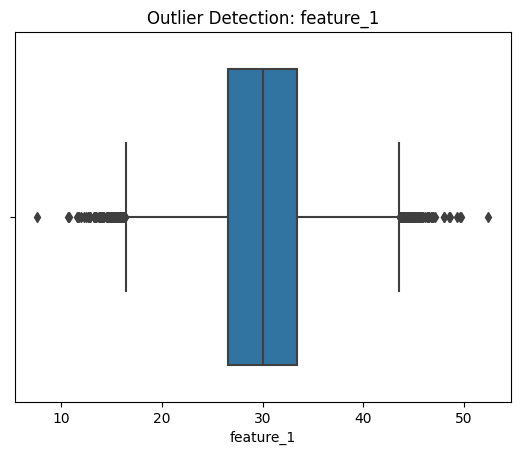

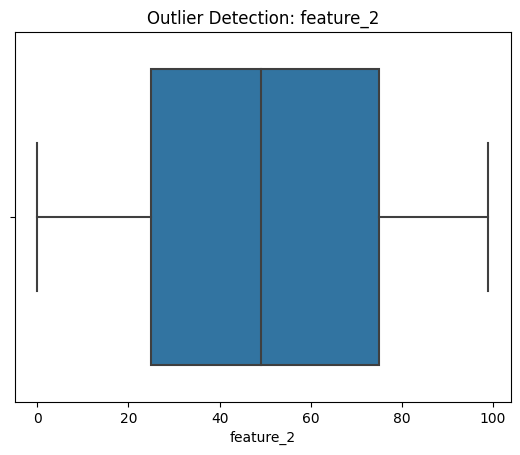

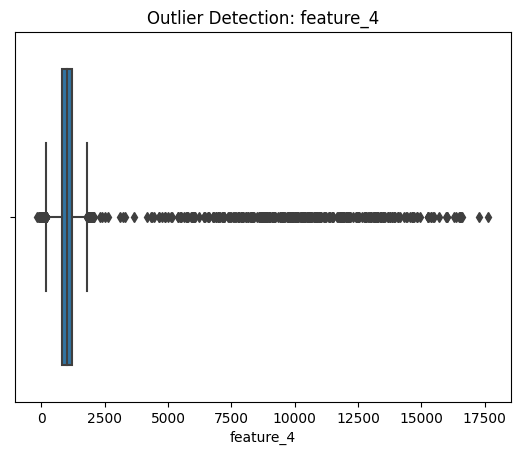

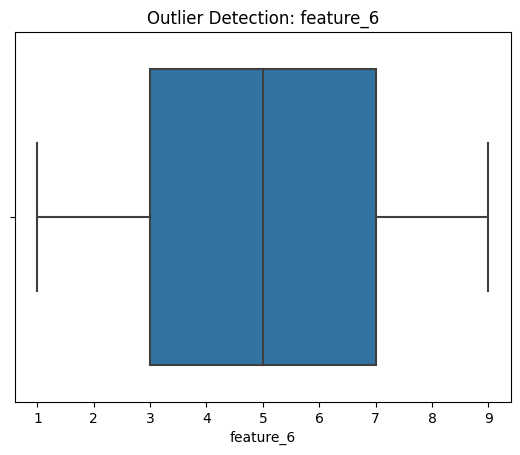

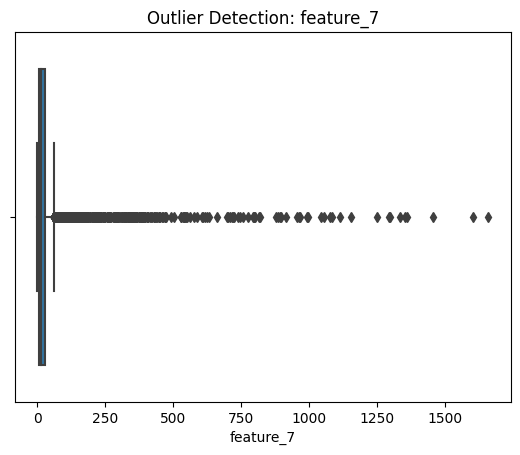

In [33]:
for feature in numerical_cols:
    plt.figure()
    sns.boxplot(x=df[feature])
    plt.title(f'Outlier Detection: {feature}')
    plt.xlabel(feature)
    plt.show()

In [34]:
# Remove outliers using IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

In [35]:
# Convert nulls
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [36]:
# Split data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Normalize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 0.61 seconds


In [38]:
# To store logs
cpu_log, mem_log, gpu_log = [], [], []
# Custom callback to log resource usage
class ResourceLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # CPU and RAM
        cpu = psutil.cpu_percent()
        mem = psutil.virtual_memory().percent

        # GPU: get memory usage from nvidia-smi
        try:
            output = subprocess.check_output(
                ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used',
                 '--format=csv,noheader,nounits'])
            gpu_util, gpu_mem = map(int, output.decode().strip().split(', '))
        except Exception as e:
            gpu_util, gpu_mem = 0, 0  # fallback if no GPU

        cpu_log.append(cpu)
        mem_log.append(mem)
        gpu_log.append(gpu_mem)

        print(f"[Epoch {epoch+1}] CPU: {cpu}%, RAM: {mem}%, GPU Memory Used: {gpu_mem} MB")


# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[ResourceLogger()])

# Evaluate
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5938 - auc_2: 0.5042 - loss: 0.6783[Epoch 1] CPU: 5.3%, RAM: 6.6%, GPU Memory Used: 405 MB
302/302 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5938 - auc_2: 0.5041 - loss: 0.6783 - val_accuracy: 0.5931 - val_auc_2: 0.4971 - val_loss: 0.6779
Epoch 2/100
272/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6040 - auc_2: 0.4998 - loss: 0.6742[Epoch 2] CPU: 39.8%, RAM: 6.6%, GPU Memory Used: 405 MB
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6042 - auc_2: 0.4993 - loss: 0.6742 - val_accuracy: 0.5931 - val_auc_2: 0.4992 - val_loss: 0.6766
Epoch 3/100
272/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6098 - auc_2: 0.5046 - loss: 0.6705[Epoch 3] CPU: 40.2%, RAM: 6.6%, GPU Memory Used: 405 MB
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6094 - auc_2: 0.5041 - loss: 0.6707 - val_accuracy: 0.5931 - val_auc_2: 0.4907 - val_loss: 0.6763
Epoch 4/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [39]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 71.35 seconds


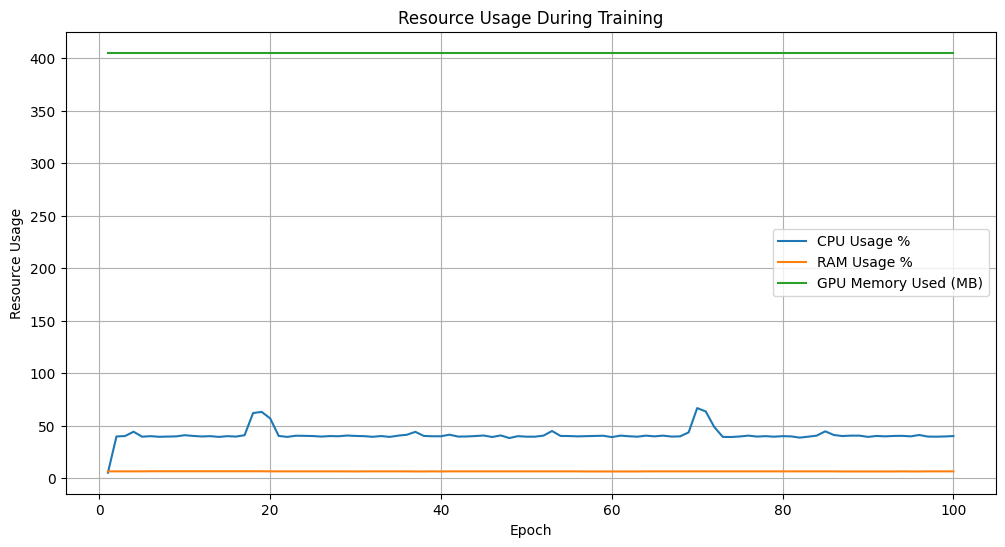

In [40]:
epochs = list(range(1, len(cpu_log)+1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, cpu_log, label='CPU Usage %')
plt.plot(epochs, mem_log, label='RAM Usage %')
plt.plot(epochs, gpu_log, label='GPU Memory Used (MB)')
plt.xlabel("Epoch")
plt.ylabel("Resource Usage")
plt.title("Resource Usage During Training")
plt.legend()
plt.grid(True)
plt.show()
